# Tutorial I: CellSNAP Analysis on Murine-spleen Data (without morphology)

In this tutorial, we provide a step-by-step analysis on the murine-spleen dataset using CellSNAP. We use single cell expression profile and location information to generate cell embeddings using SNAP-GNN-duo and use this for downstream analysis. 

## Step 0: Install packages

In [1]:
!python -m pip install cellsnap==0.1.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 4.7 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=e4c460b96b5b536dceb1566314ce7cd326a7c808af86fd509d3a63214791b2b1
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import skimage
import sys
sys.path.append("../src/cellsnap/")
from cellsnap.utils import *
import os
from tqdm import tqdm
from skimage.io import imread
from cellsnap.preprocessing import *
from cellsnap.datasets import *
from cellsnap.cellsnap import *



In [3]:
from IPython import get_ipython
if 'google.colab' in str(get_ipython()):
  RUN_COLAB = True
else:
  RUN_COLAB = False

# For local testing, we can simply set RUN_COLAB = False if any error is encountered in this block

## Step I: Create spatial dataset

We first load the codex murine dataset

In [5]:
if RUN_COLAB:
  df = pd.read_csv('/content/features_and_metadata.csv', index_col = 0)
else:
  df = pd.read_csv('../data/codex_murine/features_and_metadata.csv', index_col = 0)

In [6]:
df.head()

,Unnamed: 0,cellLabelInImage,cellSize,CD45,Ly6C,TCR,Ly6G,CD19,CD169,CD106,...,CD35,CD2135,CD44,nucl,NKp46,cluster.term,centroid_x,centroid_y,field_of_view,cluster.termV2
0,1,3,283,0.000000,316.262419,595.768897,49.077602,608.994748,322.609557,0.000000,...,217.914412,69.250551,0.000000,9100.068826,572.555576,Other,7.717314,240.809187,1,Vessel
1,4,7,215,0.000000,0.000000,134.472468,0.000000,1431.469046,73.665657,0.000000,...,1135.190597,96.309696,0.000000,15071.640583,0.000000,B,5.916279,1334.600000,1,Other
2,5,11,397,0.000000,372.035233,899.713809,261.276071,605.481258,1023.287300,1152.344425,...,488.606413,245.895189,236.229915,16381.046106,769.252953,Other,9.277078,1167.989924,1,Vessel
3,7,13,500,2966.989105,337.537437,329.896108,37.743424,671.873764,51.828695,49.372156,...,0.000000,0.000000,942.795851,2283.347509,312.484433,B,11.430000,1026.952000,1,B
4,9,15,838,3797.157518,665.627685,1938.002387,368.658711,2616.937947,1682.991647,3003.585919,...,1822.097852,392.223150,5141.479714,23181.488067,575.791169,Mph,10.233890,656.547733,1,Mph


In [7]:
features_list = [
        'CD45',
        'Ly6C',
        'TCR',
        'Ly6G',
        'CD19',
        'CD169',
        'CD106',
        'CD3',
        'CD1632',
        'CD8a',
        'CD90',
        'F480',
        'CD11c',
        'Ter119',
        'CD11b',
        'IgD',
        'CD27',
        'CD5',
        'CD79b',
        'CD71',
        'CD31',
        'CD4',
        'IgM',
        'B220',
        'ERTR7',
        'MHCII',
        'CD35',
        'CD2135',
        'CD44',
        'nucl',
        'NKp46'
    ]

In [8]:
# optionally, clean data Nans
df.fillna(0, inplace=True)

murine_dataset = SNAP_Dataset(df,
                              features_list=features_list,
                              nbhd_composition=15,
                              feature_neighbor=15,
                              spatial_neighbor=15,
                              path2img='../../data/tutorial/codex_murine/processed_images')

### Initialize the dataset

In [9]:
murine_dataset.initialize(cent_x="centroid_x",
                          cent_y="centroid_y",
                          celltype="feature_labels",
                          pca_components=25,
                          cluster_res=1.0)

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Leiden clustering identified 22 clusters as input population identity.
Calculating cell neighborhood composition matrix...
Constructing the graph...


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Done!


In [10]:
murine_dataset.dual_labels.shape

(53500, 44)

Another option is to perform initialization with human annotation

In [19]:
# murine_dataset.initialize(cent_x="centroid_x",
#                           cent_y="centroid_y",
#                           celltype="cluster.termV2",
#                           pca_components=25)

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Leiden clustering identified 22 clusters as input population identity.
Calculating cell neighborhood composition matrix...
Constructing the graph...


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Done!


## Step II: Train CellSNAP

There are two steps for training CellSNAP:


1.  Train SNAP-CNN to get CNN embedding (we skip here for tutorial since we already have the CNN embedding)
2.  Train SNAP-GNN to get GNN embedding

If there is not CNN embedding available, we can simple set `cnn_model=False` to run SNAP-GNN only

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
murine_cellsnap = CellSNAP(murine_dataset,
                           device,
                           cnn_model=True,
                           cnn_latent_dim=128,
                           gnn_latent_dim=32)


In [12]:
# load CNN embedding here
if RUN_COLAB:
  murine_cellsnap.cnn_embedding = np.load('/content/SNAP_CNN_embedding.npy')
else:
  murine_cellsnap.cnn_embedding = np.load('data/codex_murine/results/SNAP_CNN_embedding.npy')

### Train SNAP GNN

In [ ]:
murine_cellsnap.get_snap_embedding(round=5,
                                   k=32,
                                   learning_rate=1e-3,
                                   n_epochs=5000,
                                   loss_fn='MSELoss',
                                   OptimizerAlg='Adam',
                                   optimizer_kwargs={},
                                   SchedulerAlg=None,
                                   scheduler_kwargs={},
                                   verbose=True)

## Step III: SNAP Clustering & Visualization

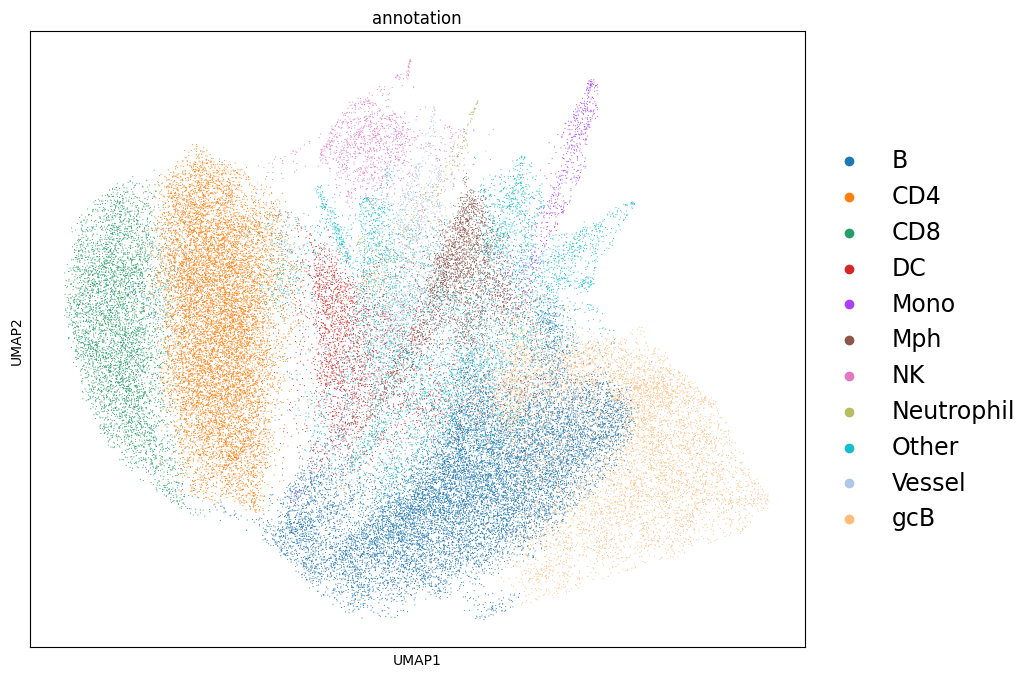

In [15]:
murine_cellsnap.visualize_umap(murine_dataset.features, murine_dataset.df['cluster.termV2'])

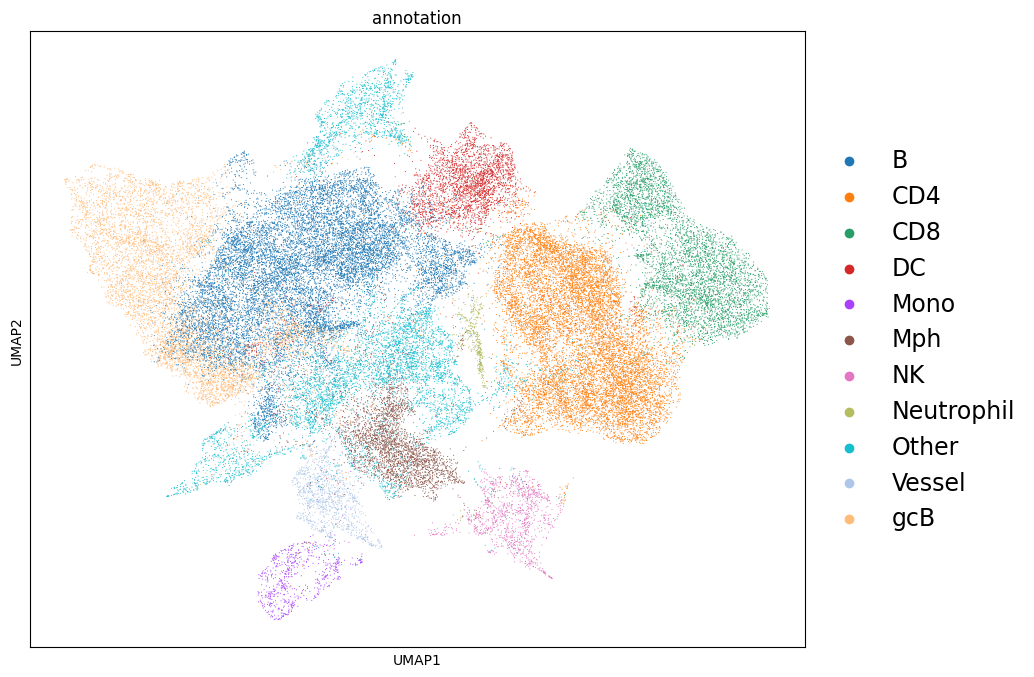

In [16]:
murine_cellsnap.visualize_umap(murine_cellsnap.snap_embedding, murine_dataset.df['cluster.termV2'])

We can also calculate cell clustering based on SNAP embedding.

In [17]:
murine_cellsnap.get_snap_clustering(neighbor=15, resolution=1.0)

/usr/local/lib/python3.10/dist-packages/cellsnap/cellsnap.py:417: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(snap_adata, resolution=resolution)


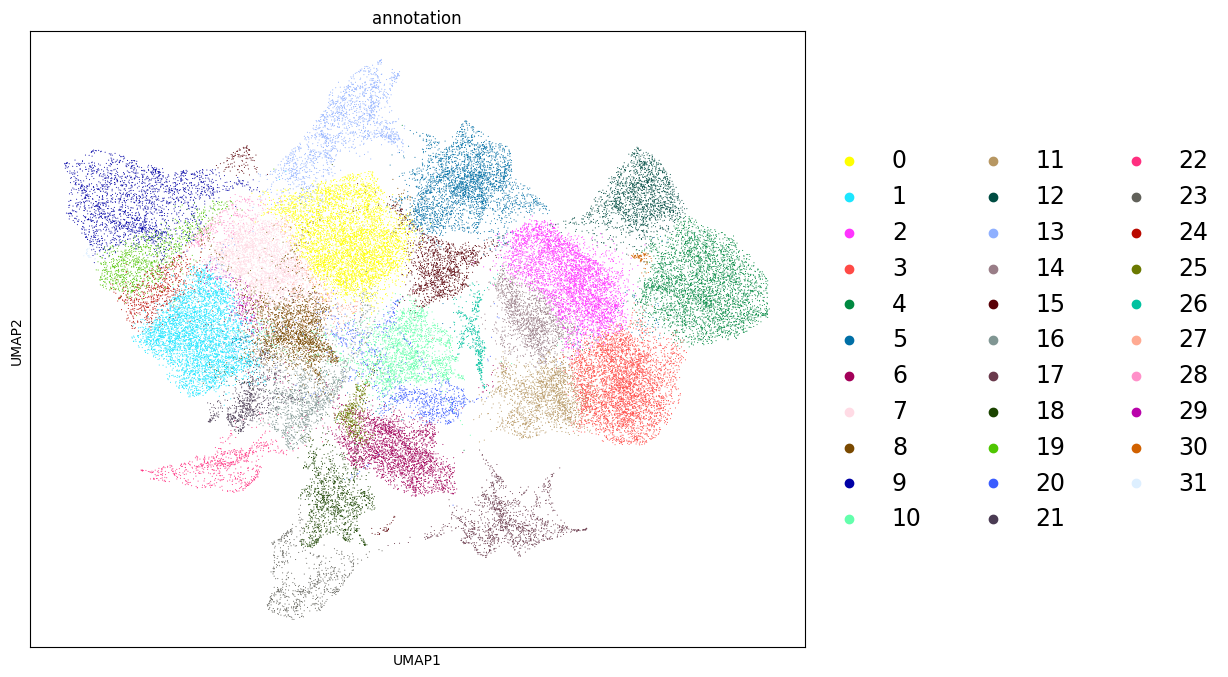

In [18]:
murine_cellsnap.visualize_umap(murine_cellsnap.snap_embedding, murine_cellsnap.snap_clustering)

## Section IV: Train CellSNAP without morphology

This is the simplest use case of CellSNAP. When CNN embeddings are not available, we train SNAP-GNN only

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
murine_cellsnap = CellSNAP(murine_dataset,
                           device,
                           cnn_model=False,
                           cnn_latent_dim=128,
                           gnn_latent_dim=32)

In [ ]:
murine_cellsnap.get_snap_embedding(round=5,
                                   k=32,
                                   learning_rate=1e-3,
                                   n_epochs=5000,
                                   loss_fn='MSELoss',
                                   OptimizerAlg='Adam',
                                   optimizer_kwargs={},
                                   SchedulerAlg=None,
                                   scheduler_kwargs={},
                                   verbose=True)

/mnt/cloud1/sheng-projects/st_projects/spatial_clust/CellSNAP/tutorials/../src/CellSNAP/cellsnap.py:443: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(embedding)
/home/sheng/miniconda3/envs/super-resolution/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


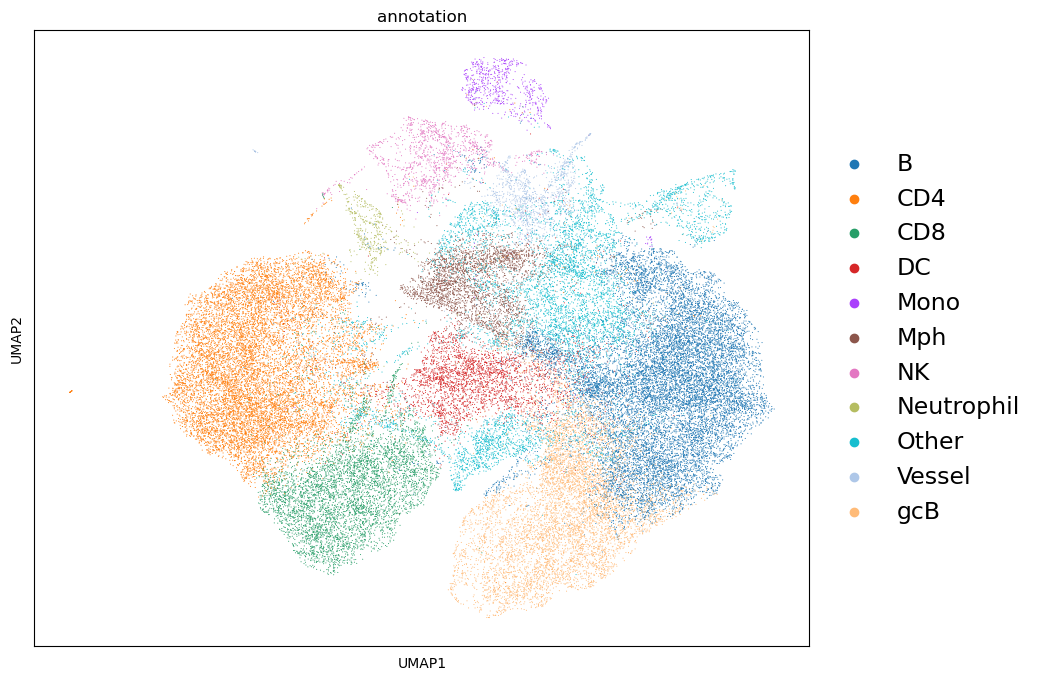

In [ ]:
murine_cellsnap.visualize_umap(murine_cellsnap.snap_embedding, murine_dataset.df['cluster.termV2'])

As before, we can perform clustering

/mnt/cloud1/sheng-projects/st_projects/spatial_clust/CellSNAP/tutorials/../src/CellSNAP/cellsnap.py:412: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  snap_adata = ad.AnnData(utils.drop_zero_variability_columns(embedding))
/mnt/cloud1/sheng-projects/st_projects/spatial_clust/CellSNAP/tutorials/../src/CellSNAP/cellsnap.py:443: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(embedding)
/home/sheng/miniconda3/envs/super-resolution/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters '

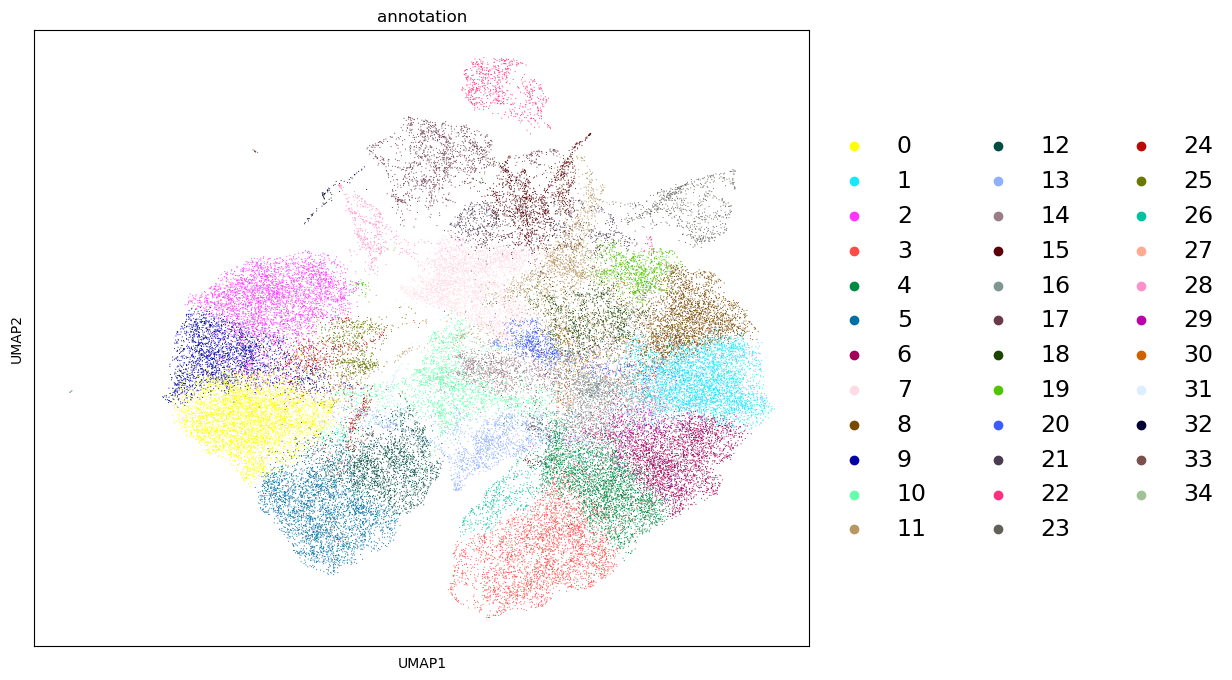

In [ ]:
murine_cellsnap.get_snap_clustering(neighbor=15, resolution=1.0)
murine_cellsnap.visualize_umap(murine_cellsnap.snap_embedding, murine_cellsnap.snap_clustering)